In [1]:
import random
import time
import numpy as np
import torch
print(torch.__version__)
import math
import os

1.4.0


In [2]:
from PIL import Image, ImageOps

In [3]:
from torch.optim import SGD, Adam, lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import  Resize
from torchvision.transforms import ToTensor, ToPILImage

In [4]:


from PIL import Image

from torch.utils.data import Dataset

from torchvision.transforms import ToTensor, ToPILImage

class idd_lite(Dataset):

    def __init__(self, root, transform=None, subset='train'):
        self.images_root = os.path.join(root, 'images/')
        self.labels_root = os.path.join(root, 'labels/')
        self.images_root += subset
        self.labels_root += subset
        self.EXTENSIONS = ['.jpg', '.png']

        
        self.filenames = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.images_root)) for f in fn if self.is_image(f)]
        self.filenames.sort()
        
        self.filenamesGt = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(self.labels_root)) for f in fn if self.is_image(f)]
        self.filenamesGt.sort()
        
        
        self.transform = transform


    def __getitem__(self, index):
        
        filename = self.filenames[index]
        filenameGt = self.filenamesGt[index]
        
        with open(self.composite_path(self.images_root, filename), 'rb') as f:
            image = self.get_image(f).convert('RGB')
        with open(self.composite_path(self.labels_root, filenameGt), 'rb') as f:
            label = self.get_image(f).convert('P')
        
        oldimage = image
        if self.transform is not None:
            image, label = self.transform(image, label)

        return image, label
    
    def __len__(self):
        return len(self.filenames)


    def get_image(self,file):
        return Image.open(file)

    def is_image(self,filename):
        return any(filename.endswith(ext) for ext in self.EXTENSIONS)

    def composite_path(self,root, name):
        return os.path.join(root, name)


In [5]:

# Importing the dataset class for VOC12 and cityscapes
# from dataset import idd_lite

import sys
print(sys.executable)

#Importing the Relabel, ToLabel and Colorize class from transform.py file
from transform import Relabel, ToLabel, Colorize
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

/home/shreyansh/anaconda3/envs/pytorch/bin/python


In [6]:
import importlib
from iouEval import iouEval, getColorEntry #importing iouEval class from the iouEval.py file
from shutil import copyfile

In [7]:
NUM_CHANNELS = 3 #RGB Images
NUM_CLASSES = 8 #IDD Lite has 8 labels or Level1 hierarchy of labels
USE_CUDA = torch.cuda.is_available() 
IMAGE_HEIGHT = 160
DATA_ROOT = '/media/shreyansh/external/shreyansh/idd20k_lite'
BATCH_SIZE = 2
NUM_WORKERS = 4
NUM_EPOCHS = 1
ENCODER_ONLY = True
device = torch.device("cuda" )
color_transform = Colorize(NUM_CLASSES)
image_transform = ToPILImage()

In [8]:
IOUTRAIN = False
IOUVAL = True

In [9]:
class MyCoTransform(object):
    def __init__(self, enc, augment=True, height=160):
        self.enc=enc
        self.augment = augment
        self.height = height
        pass
    def __call__(self, input, target):
        # Resizing data to required size
        input =  Resize((self.height,320), Image.BILINEAR)(input)
        target = Resize((self.height,320), Image.NEAREST)(target)

        if(self.augment):
            # Random horizontal flip
            hflip = random.random()
            if (hflip < 0.5):
                input = input.transpose(Image.FLIP_LEFT_RIGHT)
                target = target.transpose(Image.FLIP_LEFT_RIGHT)
            
            #Random translation 0-2 pixels (fill rest with padding)
            transX = random.randint(0, 2) 
            transY = random.randint(0, 2)

            input = ImageOps.expand(input, border=(transX,transY,0,0), fill=0)
            target = ImageOps.expand(target, border=(transX,transY,0,0), fill=7) #pad label filling with 7
            input = input.crop((0, 0, input.size[0]-transX, input.size[1]-transY))
            target = target.crop((0, 0, target.size[0]-transX, target.size[1]-transY))   
           

        input = ToTensor()(input)
        
        target = ToLabel()(target)
        
        target = Relabel(255,7)(target)
        
        return input, target

In [10]:
best_acc = 0

co_transform = MyCoTransform(ENCODER_ONLY, augment=True, height=IMAGE_HEIGHT)
co_transform_val = MyCoTransform(ENCODER_ONLY, augment=False, height=IMAGE_HEIGHT)


#train data
dataset_train = idd_lite(DATA_ROOT, co_transform, 'train')
print(len(dataset_train))
del dataset_train.filenamesGt[0::2]
print(dataset_train.filenames)
print(dataset_train.filenamesGt)

#test data
dataset_val = idd_lite(DATA_ROOT, co_transform_val, 'val')
print(len(dataset_train.filenames))
print(len(dataset_train.filenamesGt))
del dataset_val.filenamesGt[0::2]
print(dataset_val.filenames)
print(dataset_val.filenamesGt)



loader_train = DataLoader(dataset_train, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE, shuffle=True)
loader_val = DataLoader(dataset_val, num_workers=NUM_WORKERS, batch_size=1, shuffle=False)

1403
['/media/shreyansh/external/shreyansh/idd20k_lite/images/train/0/024541_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/0/024703_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/092468_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/340676_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/502201_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/601536_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/662706_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/725984_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/1/820938_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/10/092196_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/100/178149_image.jpg', '/media/shreyansh/external/shreyansh/idd20k_lite/images/train/100/206998_image

In [11]:
criterion = torch.nn.CrossEntropyLoss()

702
torch.Size([2, 1, 160, 320])


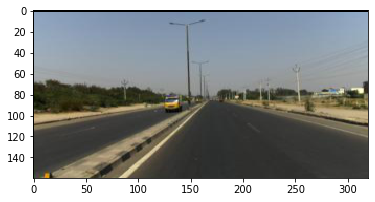

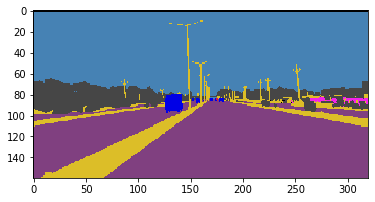

In [12]:
#get some random training images
print(len(loader_train))
#print(len(loader_val))
dataiter = iter(loader_train)
#print(dataiter.next())
(images, labels) = dataiter.next()
print(labels.shape)
#for step, (images, labels) in enumerate(loader_train):
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(ToPILImage()(Colorize()(labels[0].cpu())))  
#break

In [13]:
model_file = importlib.import_module('unet')
model = model_file.UNet(3, NUM_CLASSES).to(device)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [14]:
optimizer = Adam(model.parameters(), 5e-4, (0.9, 0.999),  eps=1e-08, weight_decay=1e-4) 
start_epoch = 1

In [15]:


print(device)



cuda


In [16]:
import os
steps_loss = 50
my_start_time = time.time()
for epoch in range(start_epoch, NUM_EPOCHS+1):
    print("----- TRAINING - EPOCH", epoch, "-----")

    epoch_loss = []
    time_train = []

    doIouTrain = IOUTRAIN   
    doIouVal =  IOUVAL      

    if (doIouTrain):
        iouEvalTrain = iouEval(NUM_CLASSES)

    model.train()
    for step, (images, labels) in enumerate(loader_train):

        start_time = time.time()
        inputs = images.to(device)
        targets = labels.to(device)
    
        outputs = model(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        loss = criterion(outputs, targets[:, 0])
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        time_train.append(time.time() - start_time)

        if (doIouTrain):
            #start_time_iou = time.time()
            iouEvalTrain.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
            #print ("Time to add confusion matrix: ", time.time() - start_time_iou)      

        # print statistics
        if steps_loss > 0 and step % steps_loss == 0:
            average = sum(epoch_loss) / len(epoch_loss)
            print('loss: {average:0.4} (epoch: {epoch}, step: {step})', "// Avg time/img: %.4f s" % (sum(time_train) / len(time_train) / BATCH_SIZE))


    average_epoch_loss_train = sum(epoch_loss) / len(epoch_loss)

    iouTrain = 0
    if (doIouTrain):
        iouTrain, iou_classes = iouEvalTrain.getIoU()
        iouStr = getColorEntry(iouTrain)+'{:0.2f}'.format(iouTrain*100) + '\033[0m'
        print ("EPOCH IoU on TRAIN set: ", iouStr, "%")  
my_end_time = time.time()
print(my_end_time - my_start_time)



----- TRAINING - EPOCH 1 -----
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1911 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1096 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1091 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1094 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1103 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1099 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1096 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1095 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1093 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1092 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1091 s
loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.1091 s
loss: {average:0.4} (epoch: {epoch}, step: {s

In [ ]:
torch.save(model,'/home/shreyansh/model_final.pth')

In [17]:
#Validate on val images after each epoch of training
print("----- VALIDATING - EPOCH", epoch, "-----")
model.eval()
epoch_loss_val = []
time_val = []

if (doIouVal):
    iouEvalVal = iouEval(NUM_CLASSES)

for step, (images, labels) in enumerate(loader_val):
    start_time = time.time()

    inputs = images.to(device)    
    targets = labels.to(device)
    
    with torch.no_grad():
        outputs = model(inputs) 
        #outputs = model(inputs)
    loss = criterion(outputs, targets[:, 0])
    epoch_loss_val.append(loss.item())
    time_val.append(time.time() - start_time)


    #Add batch to calculate TP, FP and FN for iou estimation
    if (doIouVal):
        #start_time_iou = time.time()
        iouEvalVal.addBatch(outputs.max(1)[1].unsqueeze(1).data, targets.data)
        #print ("Time to add confusion matrix: ", time.time() - start_time_iou)
        
    if steps_loss > 0 and step % steps_loss == 0:
        average = sum(epoch_loss_val) / len(epoch_loss_val)
        print('VAL loss: {average:0.4} (epoch: {epoch}, step: {step})', 
                "// Avg time/img: %.4f s" % (sum(time_val) / len(time_val) / BATCH_SIZE))


average_epoch_loss_val = sum(epoch_loss_val) / len(epoch_loss_val)

iouVal = 0
if (doIouVal):

    iouVal, iou_classes = iouEvalVal.getIoU()
    print(iou_classes)
    iouStr = getColorEntry(iouVal)+'{:0.2f}'.format(iouVal*100) + '\033[0m'
    print ("EPOCH IoU on VAL set: ", iouStr, "%")

----- VALIDATING - EPOCH 1 -----
VAL loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.0159 s
VAL loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.0156 s
VAL loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.0161 s
VAL loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.0159 s
VAL loss: {average:0.4} (epoch: {epoch}, step: {step}) // Avg time/img: 0.0158 s
tensor([0.8365, 0.0227, 0.0000, 0.3244, 0.1507, 0.6053, 0.8617],
       dtype=torch.float64)
EPOCH IoU on VAL set:  40.02 %


(160, 320, 3)
torch.Size([1, 3, 160, 320])
torch.Size([160, 320])
tensor([[6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        [6, 6, 6,  ..., 6, 6, 6],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)
[0 1 3 4 5 6 7]


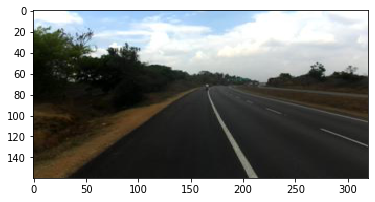

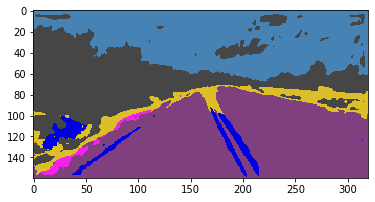

In [27]:
# Qualitative Analysis
# dataiter = iter(loader_val)
# image1,label1 = dataiter.next()
# images, labels = dataiter.next()
# print(image1)

images = "/media/shreyansh/external/shreyansh/idd20k_lite/images/test/179/760057_image.jpg"
images = Image.open(images)

images = images.resize((320,160))
images = np.array(images)
print(images.shape)
images = (images - np.min(images)) / (np.max(images) - np.min(images))
images = images.transpose((-1, 0, 1))
images = [images]
images = torch.as_tensor(images, dtype=torch.float)
print(images.shape)

if USE_CUDA:
    images = images.to(device)

inputs = images.to(device)

with torch.no_grad():
    outputs = model(inputs)
print(outputs[0].max(0)[1].shape)



label = outputs[0].max(0)[1].byte().cpu().data
print(label)

        # instances are encoded as different colors
obj_ids = np.unique(label)
print(obj_ids)
label_color = Colorize()(label.unsqueeze(0))

label_save = ToPILImage()(label_color)
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(label_save)


In [19]:
sm = torch.jit.script(model)
print(sm.code)

def forward(self,
    x: Tensor) -> Tensor:
  x1 = (self.inc).forward(x, )
  x2 = (self.down1).forward(x1, )
  x3 = (self.down2).forward(x2, )
  x4 = (self.down3).forward(x3, )
  x5 = (self.down4).forward(x4, )
  x0 = (self.up1).forward(x5, x4, )
  x6 = (self.up2).forward(x0, x3, )
  x7 = (self.up3).forward(x6, x2, )
  x8 = (self.up4).forward(x7, x1, )
  return (self.outc).forward(x8, )



In [21]:
sm.save("traced_resnet_model.pt")

In [22]:
model.save("traced.pt")

AttributeError: 'UNet' object has no attribute 'save'

torch.Size([160, 320])
torch.Size([160, 320])
[0 1 3 4 5 6 7]


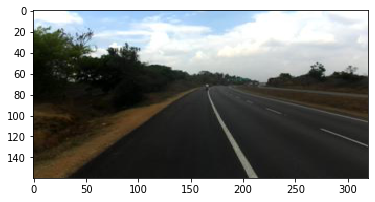

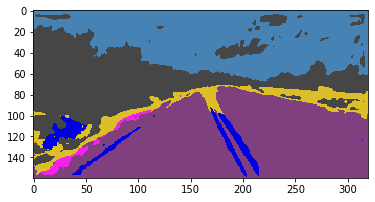

In [28]:
with torch.no_grad():
    outputs = sm(inputs)
print(outputs[0].max(0)[1].shape)



label = outputs[0].max(0)[1].byte().cpu().data
print(label.shape)

        # instances are encoded as different colors
obj_ids = np.unique(label)
print(obj_ids)
label_color = Colorize()(label.unsqueeze(0))

label_save = ToPILImage()(label_color)
plt.figure()
plt.imshow(ToPILImage()(images[0].cpu()))
plt.figure()
plt.imshow(label_save)